In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
import calendar
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go

offline.init_notebook_mode(connected = True)
df_oil = pd.read_csv('oil.csv')
df_holidays_events = pd.read_csv('holidays_events.csv')
df_sample_submission = pd.read_csv('sample_submission.csv')
df_stores = pd.read_csv('stores.csv')
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')
df_transactions = pd.read_csv('transactions.csv')


/var/folders/58/jt8r497132q6cyg8d_4hrs7r0000gn/T/ipykernel_47266/2369541734.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# label encoding categorical variables
le = LabelEncoder()
df_holidays_events['type_enc'] = le.fit_transform(df_holidays_events['type'])
df_holidays_events['locale_enc'] = le.fit_transform(df_holidays_events['locale'])
df_holidays_events['locale_name_enc'] = le.fit_transform(df_holidays_events['locale_name'])
df_holidays_events['description_enc'] = le.fit_transform(df_holidays_events['description'])
df_holidays_events['transferred_enc'] = le.fit_transform(df_holidays_events['transferred'])

df_stores['city_enc'] = le.fit_transform(df_stores['city'])
df_stores['state_enc'] = le.fit_transform(df_stores['state'])
df_stores['type_enc'] = le.fit_transform(df_stores['type'])

df_test['family_enc'] = le.fit_transform(df_test['family'])
df_train['family_enc'] = le.fit_transform(df_train['family'])

df_train.head()

,id,date,store_nbr,family,sales,onpromotion,family_enc
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,1
2,2,2013-01-01,1,BEAUTY,0.0,0,2
3,3,2013-01-01,1,BEVERAGES,0.0,0,3
4,4,2013-01-01,1,BOOKS,0.0,0,4


In [3]:
# extracting encoding labels for future reference
type_labels = df_holidays_events[['type', 'type_enc']].drop_duplicates().sort_values('type_enc')
locale_labels = df_holidays_events[['locale', 'locale_enc']].drop_duplicates().sort_values('locale_enc')
locale_name_labels = df_holidays_events[['locale_name', 'locale_name_enc']].drop_duplicates().sort_values('locale_name_enc')
description_labels = df_holidays_events[['description', 'description_enc']].drop_duplicates().sort_values('description_enc')
transferred_labels = df_holidays_events[['transferred', 'transferred_enc']].drop_duplicates().sort_values('transferred_enc')
locale_name_labels.head()

,locale_name,locale_name_enc
16,Ambato,0
12,Cayambe,1
1,Cotopaxi,2
2,Cuenca,3
14,Ecuador,4


In [4]:
import numpy as np
import pandas as pd

# Calculate median of preceding and following values
df_oil['Prev_Amount'] = df_oil['dcoilwtico'].shift(1)
df_oil['Next_Amount'] = df_oil['dcoilwtico'].shift(-1)

# Calculate the median
df_oil['Median_Prev_Next'] = df_oil[['Prev_Amount', 'Next_Amount']].median(axis=1)

# Fill null values in 'Amount' column with the calculated medians
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(df_oil['Median_Prev_Next'])

# Drop unnecessary columns
df_oill = df_oil.drop(['Prev_Amount', 'Next_Amount', 'Median_Prev_Next'], axis=1)

# Display the DataFrame
print(df_oill)


            date  dcoilwtico
0     2013-01-01       93.14
1     2013-01-02       93.14
2     2013-01-03       92.97
3     2013-01-04       93.12
4     2013-01-07       93.20
...          ...         ...
1213  2017-08-25       47.65
1214  2017-08-28       46.40
1215  2017-08-29       46.46
1216  2017-08-30       45.96
1217  2017-08-31       47.26

[1218 rows x 2 columns]


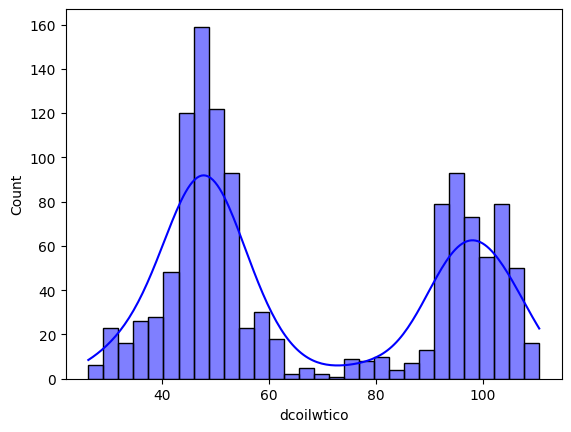

In [5]:
sns.histplot(df_oill["dcoilwtico"], bins=30, kde=True, color='blue')
plt.show()

In [6]:
# copying of train data and merging other data
df_train1 = df_train.merge(df_holidays_events, on = 'date', how='left')
df_train1 = df_train1.merge(df_oill, on = 'date', how='left')
df_train1 = df_train1.merge(df_stores, on = 'store_nbr', how='left')
df_train1 = df_train1.merge(df_transactions, on = ['date', 'store_nbr'], how='left')
df_train1 = df_train1.rename(columns = {"type_x" : "holiday_type", "type_y" : "store_type"})

df_train1['date'] = pd.to_datetime(df_train1['date'])
df_train1['year'] = df_train1['date'].dt.year
df_train1['month'] = df_train1['date'].dt.month
df_train1['week'] = df_train1['date'].dt.isocalendar().week
df_train1['quarter'] = df_train1['date'].dt.quarter
df_train1['day_of_week'] = df_train1['date'].dt.day_name()
df_train1.head()

,id,date,store_nbr,family,sales,onpromotion,family_enc,holiday_type,locale,locale_name,...,cluster,city_enc,state_enc,type_enc_y,transactions,year,month,week,quarter,day_of_week
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Holiday,National,Ecuador,...,13,18,12,3,NaN,2013,1,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,1,Holiday,National,Ecuador,...,13,18,12,3,NaN,2013,1,1,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,2,Holiday,National,Ecuador,...,13,18,12,3,NaN,2013,1,1,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,3,Holiday,National,Ecuador,...,13,18,12,3,NaN,2013,1,1,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,4,Holiday,National,Ecuador,...,13,18,12,3,NaN,2013,1,1,1,Tuesday


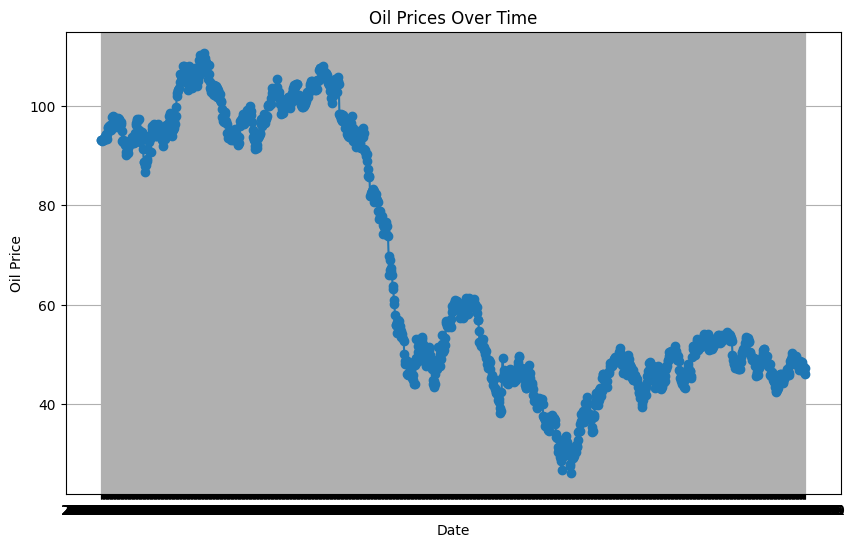

In [7]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_oil['date'], df_oil['dcoilwtico'], marker='o', linestyle='-')
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.grid(True)
plt.show()

In [8]:
# data
df_st_sa = df_train1.groupby('store_type').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
df_fa_sa = df_train1.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]
df_cl_sa = df_train1.groupby('cluster').agg({"sales" : "mean"}).reset_index() 
# chart color
df_fa_sa['color'] = '#496595'
df_fa_sa['color'][2:] = '#c6ccd8'
df_cl_sa['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3], vertical_spacing=0, horizontal_spacing=0.02,
                    subplot_titles=("Top 10 Highest Product Sales", "Highest Sales in Stores", "Clusters Vs Sales"))

fig.add_trace(go.Bar(x=df_fa_sa['sales'], y=df_fa_sa['family'], marker=dict(color= df_fa_sa['color']),
                     name='Family', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_st_sa['sales'], labels=df_st_sa['store_type'], name='Store type',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label'), 
                    row=1, col=2)
fig.add_trace(go.Bar(x=df_cl_sa['cluster'], y=df_cl_sa['sales'], 
                     marker=dict(color= df_cl_sa['color']), name='Cluster'), 
                     row=2, col=1)

# styling
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_cl_sa.cluster, ticktext=[i for i in range(1,17)], row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=500, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

/var/folders/58/jt8r497132q6cyg8d_4hrs7r0000gn/T/ipykernel_47266/1963765295.py:7: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# performing train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

NameError: name 'train_test_split' is not defined